<a href="https://colab.research.google.com/github/aman9213/DL_assignment3/blob/main/seq2seq_without_Attention__final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import os
import glob
from torch.utils.data import DataLoader,Dataset 
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy

### *mounting google drive to google colab*


In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### *Reading the data*

In [ ]:
path = '/content/drive/MyDrive/hin'
csv_files = glob.glob(os.path.join(path, "*.csv"))
print(csv_files)
test_path=csv_files[0]
train_path=csv_files[2]
valid_path=csv_files[1]
train_data=pd.read_csv(train_path)
valid_data=pd.read_csv(valid_path)
test_data=pd.read_csv(test_path)
display((valid_data))
train_data_matrix=train_data.to_numpy()
valid_data_matrix=valid_data.to_numpy()
test_data_matrix=test_data.to_numpy()
# print(train_data_matrix[:,1])
print(valid_data_matrix.shape)

['/content/drive/MyDrive/hin/hin_test.csv', '/content/drive/MyDrive/hin/hin_valid.csv', '/content/drive/MyDrive/hin/hin_train.csv']


,jaisawal,जयसवाल
0,bajai,बजाई
1,sanghthan,संघठन
2,haiwaan,हैवान
3,nilgiri,नीलगिरि
4,drutgrami,द्रुतग्रामी
...,...,...
4090,paranshu,परांशु
4091,romanchit,रोमांचित
4092,ekamreshwar,एकाम्रेश्वर
4093,bluetooth,ब्ल्यूटूथ


(4095, 2)


### Data-processing--> creating dictionary of index to character and character to index

In [ ]:
# Load the CSV data using pandas
source_train='shastragaar'
target_train='शस्त्रागार'
source_test='thermax'
target_test='थरमैक्स'
source_valid='jaisawal'
target_valid='जयसवाल'
# data = pd.read_csv('data.csv')
train_data=pd.read_csv(train_path)
test_data=pd.read_csv(test_path)
valid_data=pd.read_csv(valid_path)
# Convert the data to lowercase
train_data[source_train] = train_data[source_train].str.lower()
test_data[source_test]=test_data[source_test].str.lower()
# valid_data[source_valid]=test_data[source_valid].str.lower()

# print(train_data[source].shape)
# Clean and normalize Hindi text
def clean_text(text):
  # Remove punctuations and digits
  text = re.sub(r'[^\u0900-\u097F\s]', '', text)
  text = re.sub(r'[\d]', '', text)
  
  # Normalize text
  text = unicodedata.normalize('NFD', text)
  text = ''.join(c for c in text if unicodedata.category(c) != 'Mn')
  text = unicodedata.normalize('NFC', text)
  
  return text

train_data[target_train] = train_data[target_train].apply(clean_text)
test_data[target_test]=test_data[target_test].apply(clean_text)
valid_data[target_valid]=valid_data[target_valid].apply(clean_text)
# print(train_data)
# Tokenize the data
source_chars_train = set()
target_chars_train = set()
source_chars_test = set()
target_chars_test = set()
source_chars_valid = set()
target_chars_valid = set()
for source1, target1 in zip(train_data[source_train], train_data[target_train]):
  source_chars_train.update(source1)
  target_chars_train.update(target1)
# print(target_chars_train)
source_chars_train = sorted(list(source_chars_train))
target_chars_train = sorted(list(target_chars_train))
# print(target_chars,source_chars )
for source2, target2 in zip(test_data[source_test],test_data[target_test]):
  source_chars_test.update(source2)
  target_chars_test.update(target2)
# print(target_chars_test)
source_chars_test = sorted(list(source_chars_test))
target_chars_test = sorted(list(target_chars_test))

##############
for source3, target3 in zip(valid_data[source_valid], valid_data[target_valid]):
  source_chars_valid.update(source3)
  target_chars_valid.update(target3)
# print(target_chars_valid)
source_chars_valid = sorted(list(source_chars_valid))
target_chars_valid = sorted(list(target_chars_valid))
print("A",target_chars_test)
print((target_chars_train))
source_chars=sorted(list(set().union(source_chars_train,source_chars_test,source_chars_valid)))
target_chars=sorted(list(set().union(target_chars_train,target_chars_test,target_chars_valid )))
###character to index dictionary
source_char_to_id = {char: i for i, char in enumerate(source_chars)}
target_char_to_id = {char: i for i, char in enumerate(target_chars)}

source_char_to_id['<SOS>'] = len(source_char_to_id)
target_char_to_id['<SOS>'] = len(target_char_to_id)

source_char_to_id['<EOS>'] = len(source_char_to_id)
target_char_to_id['<EOS>'] = len(target_char_to_id)

source_char_to_id['<PAD>'] = len(source_char_to_id)
target_char_to_id['<PAD>'] = len(target_char_to_id)
## index to charcter dicitonary
source_id_to_char={i:char for i,char in enumerate(source_chars)}
target_id_to_char={i:char for i,char in enumerate(target_chars)}
print(target_char_to_id)
print(source_char_to_id)

A ['ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'ऽ', 'ा', 'ि', 'ी', 'ॉ', 'ॊ', 'ो', 'ौ']
['ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'ळ', 'व', 'श', 'ष', 'स', 'ह', 'ऽ', 'ा', 'ि', 'ी', 'ॉ', 'ो', 'ौ']
{'ः': 0, 'अ': 1, 'आ': 2, 'इ': 3, 'ई': 4, 'उ': 5, 'ऊ': 6, 'ऋ': 7, 'ए': 8, 'ऐ': 9, 'ऑ': 10, 'ओ': 11, 'औ': 12, 'क': 13, 'ख': 14, 'ग': 15, 'घ': 16, 'ङ': 17, 'च': 18, 'छ': 19, 'ज': 20, 'झ': 21, 'ञ': 22, 'ट': 23, 'ठ': 24, 'ड': 25, 'ढ': 26, 'ण': 27, 'त': 28, 'थ': 29, 'द': 30, 'ध': 31, 'न': 32, 'प': 33, 'फ': 34, 'ब': 35, 'भ': 36, 'म': 37, 'य': 38, 'र': 39, 'ल': 40, 'ळ': 41, 'व': 42, 'श': 43, 'ष': 44, 'स': 45, 'ह': 46, 'ऽ': 47, 'ा': 48, 'ि': 49, 'ी': 50, 'ॉ': 51, 'ॊ

In [ ]:
def tokenize(source,target,path):
  ## source: column heading of input column in csv file
  ## target: column heading of target column in csv file

  # Load the CSV data using pandas
  data=pd.read_csv(path)
  # Convert the data to lowercase
  data[source] = data[source].str.lower()

  # Clean and normalize Hindi text
  def clean_text(text):
    # Remove punctuations and digits
    text = re.sub(r'[^\u0900-\u097F\s]', '', text)
    text = re.sub(r'[\d]', '', text)

    # Normalize text
    text = unicodedata.normalize('NFD', text)
    text = ''.join(c for c in text if unicodedata.category(c) != 'Mn')
    text = unicodedata.normalize('NFC', text)

    return text

  data[target] = data[target].apply(clean_text)
  

  # Convert characters to numerical values
  data_numerical = []


  for src, targ in zip(data[source], data[target]):
      
    source_numerical = [source_char_to_id[char] for char in src]
    target_numerical = [target_char_to_id[char] for char in targ]
    source_numerical=[source_char_to_id['<SOS>']]+source_numerical+[source_char_to_id['<EOS>']]+[source_char_to_id['<PAD>']]*(28-len(src)-2)
    target_numerical=[target_char_to_id['<SOS>']]+target_numerical+[target_char_to_id['<EOS>']]+[target_char_to_id['<PAD>']]*(20-len(targ)-2)
    
    data_numerical.append([source_numerical, target_numerical])
  return data_numerical

In [ ]:
train_data_numerical=tokenize('shastragaar','शस्त्रागार',train_path)
valid_data_numerical=tokenize('jaisawal','जयसवाल',valid_path,)
test_data_numerical=tokenize('thermax','थरमैक्स',test_path)


### class AksharantarDataset is for making tokenized data iteratable

In [ ]:

class AksharantarDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
  
    return len(self.data)

  def __getitem__(self, index):
      
    source, target = self.data[index]
    source_tensor = torch.tensor(source, dtype=torch.long)
    target_tensor = torch.tensor(target, dtype=torch.long)
#         print('--->insidedataloader ',index,source_tensor.shape,target_tensor.shape)
      
    return source_tensor, target_tensor


In [ ]:
train_set=AksharantarDataset(train_data_numerical)
valid_set=AksharantarDataset(valid_data_numerical)
test_set=AksharantarDataset(test_data_numerical)

### giving the data to Dataloader

In [ ]:
train_data_set=DataLoader(train_set, batch_size=64, shuffle=True)
valid_data_set=DataLoader(valid_set, batch_size=64, shuffle=False)
test_data_set=DataLoader(test_set, batch_size=64, shuffle=False)
print(len(train_data_set))
print(len(valid_data_set))
print(len(test_data_set))

800
64
64


### Building the model

In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_size,embedding_size,hidden_size,num_encoder_layer,dropout,input_vocab_size,bidirection,cell_type):
    
  ### parameters:
     # input_size=> length of input to encoder
     # embedding_size=> embedding length for each character in embedding layer
     # hidden_size=> hidden size of encoder hidden states
     # num_encoder_layer=> number of encoder layer in encoder
     # dropout= dropout ratio appied in fc layer
     # input_vocab_size=> vocab length of input which is 29
     # bidirection => [True,False]
     # cell_type => 'LSTM','RNN','GRU'
     

    super(Encoder,self).__init__()
    self.input_size = input_size
    self.cell_type=cell_type
    #self.embedding_size = embeddings_size
    self.bidirection=bidirection
    self.hidden_size=hidden_size
    self.num_encoder_layer=num_encoder_layer
    self.dropout=nn.Dropout(dropout)
    self.embedding=nn.Embedding(input_vocab_size,embedding_size)
    if cell_type=='LSTM':
      if num_encoder_layer!=1: 
        self.rnn=nn.LSTM(embedding_size,hidden_size,num_encoder_layer,dropout=dropout,bidirectional=bidirection)
      else:
        self.rnn=nn.LSTM(embedding_size,hidden_size,num_encoder_layer,bidirectional=bidirection)
    elif cell_type=='GRU':
      if num_encoder_layer!=1:
        self.rnn=nn.GRU(embedding_size,hidden_size,num_encoder_layer,dropout=dropout,bidirectional=bidirection)
      else:
        self.rnn=nn.GRU(embedding_size,hidden_size,num_encoder_layer,bidirectional=bidirection)

    elif cell_type=='RNN':
      if num_encoder_layer!=1:
        self.rnn=nn.RNN(embedding_size,hidden_size,num_encoder_layer,dropout=dropout,bidirectional=bidirection)
      else:
        self.rnn=nn.RNN(embedding_size,hidden_size,num_encoder_layer,bidirectional=bidirection)



  def forward(self,inputs):
      
    batch_size=inputs.shape[0]
    
    if self.bidirection:
      
      h0=torch.randn(2*self.num_encoder_layer,batch_size,self.hidden_size).to(device)
      
      if self.cell_type=='LSTM':
        c0=torch.randn(2*self.num_encoder_layer,batch_size,self.hidden_size).to(device)
    else:
      
      h0=torch.randn(self.num_encoder_layer,batch_size,self.hidden_size).to(device)
      
      if self.cell_type=='LSTM':
        c0=torch.randn(self.num_encoder_layer,batch_size,self.hidden_size).to(device)
    embedding=self.dropout(self.embedding(inputs)) ### (batch,28,embedding_size)
    embedding=torch.permute(embedding,(1,0,2))     ##(28,batch,embedding)
    if self.cell_type=='LSTM':
      output,(hidden,cell)=self.rnn(embedding,(h0,c0))
      return hidden, cell
    else:
      output,hidden=self.rnn(embedding,h0)
      cell=None
      return hidden,cell
    # print("CC",output.shape,hidden.shape)

class Decoder(nn.Module):
  def __init__(self,input_size,embedding_size,hidden_size,output_vocab_size,num_decoder_layer,dropout,bidirection,cell_type):

    ### parameters:
      # input_size=> length of input to encoder
      # embedding_size=> embedding length for each character in embedding layer
      # hidden_size=> hidden size of encoder hidden states
      # num_encoder_layer=> number of encoder layer in encoder
      # dropout= dropout ratio appied in fc layer
      # input_vocab_size=> vocab length of input which is 29
      # bidirection => [True,False]
      # cell_type => 'LSTM','RNN','GRU'


    super(Decoder,self).__init__()
    self.hidden_size=hidden_size
    self.cell_type=cell_type
    self.num_decoder_layer=num_decoder_layer
    self.dropout=nn.Dropout(dropout)
    self.embedding=nn.Embedding(output_vocab_size+3,embedding_size)       ## +3 because there are total 54+3=57 unique token
    if cell_type=='LSTM':

      if num_decoder_layer!=1:
        self.rnn=nn.LSTM(embedding_size,hidden_size,num_decoder_layer,dropout=dropout,bidirectional=bidirection)
      else:
        self.rnn=nn.LSTM(embedding_size,hidden_size,num_decoder_layer,bidirectional=bidirection)

    elif cell_type=='GRU':
      if num_decoder_layer!=1:
        self.rnn=nn.GRU(embedding_size,hidden_size,num_decoder_layer,dropout=dropout,bidirectional=bidirection)
      else:
        self.rnn=nn.GRU(embedding_size,hidden_size,num_decoder_layer,bidirectional=bidirection)
    elif cell_type=='RNN':
      if num_decoder_layer!=1:
        self.rnn=nn.RNN(embedding_size,hidden_size,num_decoder_layer,dropout=dropout,bidirectional=bidirection)
      else:
        self.rnn=nn.RNN(embedding_size,hidden_size,num_decoder_layer,bidirectional=bidirection)
        
    if bidirection:
      self.fc=nn.Linear(hidden_size*2,output_vocab_size+3)#----------------------------------------------------
    else:
      self.fc=nn.Linear(hidden_size,output_vocab_size+3)
  def forward(self,x,hidden,cell):

    x=x.unsqueeze(0)  
    embedding=self.dropout(self.embedding(x)) 
  
    if self.cell_type=='LSTM':  
      output,(hidden,cell)=self.rnn(embedding,(hidden,cell)) 
      
    else:
  
      output,hidden=self.rnn(embedding,hidden)
      cell=None
      
    prediction=self.fc(output)
    #prediction=F.softmax(prediction,dim=1)
    prediction=prediction.squeeze(0)
    
    return prediction,hidden,cell
    
      
        
    
class seq2seq(nn.Module):
  ## this class will connect the encoder and decoder and generate the output
  def __init__(self,encoder,decoder):

    super(seq2seq,self).__init__()
    self.encoder=encoder
    self.decoder=decoder
      
  def forward(self,source,target,teacher_forceing=0.5):

    ## parameters:
     # source-> batch of input words
     # target-> batch of target words
     # teacher_forceing-> 0.5
    batch_size=source.shape[0]#64
    self.target=target
    self.target_len=target.shape[1]#20
    
    target_vocab_size=55 
    outputs=torch.zeros(self.target_len,batch_size,target_vocab_size+3).to(device)#--------------------------

    hidden,cell=self.encoder(source)
    # print("D",hidden.shape)
    x=target[:,0] ## for grabing <sos> token  
   
    
    for t in range(0,self.target_len):
      # print("C")
      pred,hidden,cell=self.decoder(x,hidden,cell)  ##or there error
      # print("E",hidden.shape)
#             print(pred.shape) 64x57
#             print(hidden.shape) 4x64x256
      outputs[t]=pred
      best_guess=pred.argmax(1)
#             print("best",best_guess.shape) 64 batch of each time step
      x=target[:,t] if random.random()<teacher_forceing else best_guess
#             print('D',target[:,t])
    return outputs


  def prediction(self,sources):
    batch_size=sources.shape[0]
    # print("A",input.shape)
    target_vocab_size=55

    outputs=torch.zeros(self.target_len,batch_size,target_vocab_size+3).to(device)#--------------------------

    hidden,cell=self.encoder(sources)

    x=sources[:,0] ## for grabing <sos> token  

    
    for t in range(0,self.target_len):
      # print("B",hidden.shape)
      pred,hidden,cell=self.decoder(x,hidden,cell)  ##or there error
      # print("C")
#             print(pred.shape) 64x57
#             print(hidden.shape) 4x64x256
      outputs[t]=pred
      best_guess=pred.argmax(1)
#             print("best",best_guess.shape) 64 batch of each time step
      x=best_guess
    return outputs
    
        
    
    

In [ ]:
# !pip install wandb

In [ ]:
# import wandb

In [ ]:
# !wandb login --relogin

### below cell is for sweeping over hyperparameters

In [ ]:
# sweep_configuration={'name':'EE22s037','method':'bayes',
#                      'metric':{'name':'val_acc','goal':'maximize'},
#                      'parameters':{'embedding_size':{'values':[64,128,256]},
#                                   'num_encoder_layer':{'values':[1,2,3]},
#                                   # 'num_decoder_layer':{'values':[1,2,3]},
#                                   'hidden_layer_size':{'values':[64,256,512]},
#                                   'cell_type':{'values':['LSTM','GRU']},
#                                   'dropout':{'values':[0.2,0.3]},
#                                   'bidirection':{'values':[True,False]}
                         
#                                  }
    
#                     }


# def train():

#   wandb.init()
#   epochs=20
#   learning_rate=0.0001
#   batch_size=64
  
#   load_model=False
#   input_size_encoder=28
#   input_size_decoder=20
#   input_vocab_size=29
#   output_vocab_size=55
#   cell_type=wandb.config.cell_type
#   encoder_embedding_size=wandb.config.embedding_size
#   decoder_embedding_size=wandb.config.embedding_size
#   hidden_size=wandb.config.hidden_layer_size
#   num_encoder_layers=wandb.config.num_encoder_layer
#   num_decoder_layers=wandb.config.num_encoder_layer
#   enc_dropout=wandb.config.dropout
#   dec_dropout=wandb.config.dropout
#   bidirection=wandb.config.bidirection
#   run_name="ees_{}_des_{}_hs_{}_nel_{}_ndl_{}_ed_{}_dd_{}_ct_{}_bd_{}".format(encoder_embedding_size,decoder_embedding_size,hidden_size,num_encoder_layers,num_decoder_layers,enc_dropout,dec_dropout,cell_type,bidirection)
#   print("run_name:",run_name)
#   encoder_net=Encoder(input_size_encoder,encoder_embedding_size,
#                   hidden_size,num_encoder_layers,enc_dropout,input_vocab_size,bidirection,cell_type).to(device)
#   decoder_net=Decoder(input_size_decoder,decoder_embedding_size,
#                   hidden_size,output_vocab_size,num_decoder_layers,dec_dropout,bidirection,cell_type).to(device)

#   model=seq2seq(encoder_net,decoder_net).to(device)
#   optimizer = optim.Adam(model.parameters(), lr=learning_rate)   
#   criterion=nn.CrossEntropyLoss()#ignore_index=output_vocab_size)
#   best_accuracy=0
#   train_Loss=[]
#   train_Acc_char=[]
#   # train_Acc_word=[]
#   val_Loss=[]
#   val_Acc_char=[]
#   val_Acc_word=[]
#   for epoch in range(epochs):

  
#     model.train()
#     train_accuracy_char=0.0
#     num_correct_train_char=0
#     train_accuracy_word=0
#     train_loss = 0.0
#     num_correct_train_word=0
#     for i, (inputs, target) in enumerate(train_data_set):
        
#       inputs=inputs.to(device)
#       target=target.to(device)

#       optimizer.zero_grad()
      
#       output = model(inputs,target)
#       output=torch.permute(output,(1,0,2))
#       # print(output.shape)
#       output1=output[1:].reshape(-1,output.shape[2])
      
#       target1=target[1:].reshape(-1)
    

#       loss = criterion(output1, target1)
      
#       loss.backward()
#       torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm = 1)
#       optimizer.step()
#       train_loss += loss.item()
#       predict=F.softmax(output,dim=1)
#       predictionss=torch.argmax(predict,dim=2)#20x64
      
#       # predictionss=torch.permute(predictionss,(1,0))#64x20
      
#       # print("pred",predictionss[])
#       num_correct_train_char += (predictionss == target).sum().item()

#       # # FINDING WORD LEVEL ACCURACY
#       # z=(predictionss == target).sum(-1)
        
#       # num_correct_train_word+=(z==20).sum().item()

#       # for j in range(len(predictionss)): #len(predictions)=64 and len(predictions[j])=20
#       #   predicted_sentence = ''
#       #   target_sentence = ''
#       #   for k in range(len(predictionss[j])):
#       #     if (predictionss[j][k].item()!=55 and predictionss[j][k].item()!=56 and predictionss[j][k].item()!=57) and (target[j][k].item()!=55 and target[j][k].item()!=56 and target[j][k].item()!=57 ): 
#       #       predicted_sentence += target_id_to_char[predictionss[j][k].item()]
            
#       #       target_sentence += target_id_to_char[target[j][k].item()]
#       #   if predicted_sentence==target_sentence:
#       #     num_correct_train_word+=1
    

#     train_accuracy_char= (num_correct_train_char/(len(train_data_set)*batch_size*20))*100 
#     train_loss=(train_loss/(len(train_data_set)*batch_size))*100
#     # train_accuracy_word= (num_correct_train_word/(len(train_data_set)*batch_size))*100
#     train_Acc_char.append(train_accuracy_char)
#     train_Loss.append(train_loss)


#     # print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, epochs, running_loss/(len(train_data_set)*batch_size)))

#     model.eval()
#     val_loss = 0.0
#     val_accuracy_char=0.0
#     num_correct_val_char=0
#     val_accuracy_word=0
#     num_correct_val_word=0
#     with torch.no_grad():
#       for i, (inputs, target) in enumerate(valid_data_set):
#         inputs=inputs.to(device)

#         target=target.to(device)
        
#         output = model.prediction(inputs)#20x64x58
        
#         output=torch.permute(output,(1,0,2))#64x20x58
#         output1=output[1:].reshape(-1,output.shape[2])  ########################3
        
#         # output1=output[1:].argmax(2).reshape(-1)
#         target1=target[1:].reshape(-1)
        
#         loss = criterion(output1, target1)
        
#         val_loss += loss.item()
#         predict=F.softmax(output,dim=1)
#         predictionss=torch.argmax(predict,dim=2)#20x64
#         # predictionss=torch.permute(predictionss,(1,0))#64x20
#         num_correct_val_char += (predictionss == target).sum().item()
#         # z=(predictionss == target).sum(-1)
#         # num_correct_val_word+=(z==20).sum().item()
#         for j in range(len(predictionss)): #len(predictions)=64 and len(predictions[j])=20
#           predicted_sentence = ''
#           target_sentence = ''
#           for k in range(len(predictionss[j])):
#             if (predictionss[j][k].item()!=55 and predictionss[j][k].item()!=56 and predictionss[j][k].item()!=57) and (target[j][k].item()!=55 and target[j][k].item()!=56 and target[j][k].item()!=57 ): 
#               predicted_sentence += target_id_to_char[predictionss[j][k].item()]
              
#               target_sentence += target_id_to_char[target[j][k].item()]
#           if predicted_sentence==target_sentence:
#             num_correct_val_word+=1


#       # print("A",output[0])
#       # print("B",predict)
#       # print("C",predictionss[0])
#       # print("D",target[0])
#       val_loss=(train_loss/(len(valid_data_set)*batch_size))*100
#       val_accuracy_char=(num_correct_val_char/(len(valid_data_set)*batch_size*20))*100
#       val_accuracy_word=(num_correct_val_word/(len(valid_data_set)*batch_size))*100
#       val_Acc_char.append(val_accuracy_char)
#       val_Loss.append(val_loss)
#       val_Acc_word.append(val_accuracy_word)
#     wandb.log({#'epoch':e,
            
#             'train_loss':train_loss,
#             'val_acc': val_accuracy_char,
#             'val_loss':val_loss ,
#             'val_accuracy_word':val_accuracy_word      
#           })

#   print("max__train_accuracy_char:",np.max(train_Acc_char))
#   print("max__validation_accuracy_char:",np.max(val_Acc_char))
#   print("min_train_loss:",np.min(train_Loss))
#   print("min_validation_loss:",np.min(val_Loss))
#   print("max__validation_accuracy_word:",np.max(val_Acc_word))
#   plt.plot(train_Loss, 'r', label="Training loss")
#   plt.plot(val_Loss, 'lime', label="Validation loss")
#   plt.title("Training and Validation Loss vs Number of Epochs", size=15)
#   plt.xlabel("Number of epochs", size=15)
#   plt.ylabel("Loss", size=15)
#   plt.legend()
#   plt.show()


#   plt.plot(train_Acc_char, 'r', label="Training Accuracy")
#   plt.plot(val_Acc_char ,'lime', label="Validation Accuracy_char")
#   plt.plot(val_Acc_word,'b',label="Validation Accuracy_word")
#   plt.title("Training and Validation Accuracy vs Number of Epochs", size=15)
#   plt.xlabel("Number of epochs", size=15)
#   plt.ylabel("Accuracy", size=15)
#   plt.legend()
#   plt.show()   
#   wandb.run.name = run_name
#   wandb.run.save()
#   wandb.run.finish()

# sweep_id=wandb.sweep(sweep=sweep_configuration,entity="amanvb-9213",project='DL-assignment3')
# # sweep_id=
# wandb.agent(sweep_id,function=train,count=25)
# # wandb.agent(sweep_id,function=train,entity="amanvb-9213",project='DL-assignment3')




### training with best hyperparameter

In [ ]:
def train_best_model():

  
  epochs=30
  learning_rate=0.0001
  batch_size=64
  
  load_model=True
  input_size_encoder=28  ##length of input
  input_size_decoder=20  ## length of output
  input_vocab_size=29    ## vocabulary size of input data
  output_vocab_size=55   ## vocabulary sizeof output data
  cell_type='LSTM'
  encoder_embedding_size=256
  decoder_embedding_size=256
  hidden_size=512
  num_encoder_layers=3
  num_decoder_layers=3
  enc_dropout=0.3
  dec_dropout=0.3
  bidirection=True

  encoder_net=Encoder(input_size_encoder,encoder_embedding_size,
                  hidden_size,num_encoder_layers,enc_dropout,input_vocab_size,bidirection,cell_type).to(device)
  decoder_net=Decoder(input_size_decoder,decoder_embedding_size,
                  hidden_size,output_vocab_size,num_decoder_layers,dec_dropout,bidirection,cell_type).to(device)

  model=seq2seq(encoder_net,decoder_net).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)   
  criterion=nn.CrossEntropyLoss()
  best_accuracy=0
  train_Loss=[]
  train_Acc_char=[]
  # train_Acc_word=[]
  val_Loss=[]
  val_Acc_char=[]
  val_Acc_word=[]
  for epoch in range(epochs):

  
    model.train()
    train_accuracy_char=0.0
    num_correct_train_char=0
    train_accuracy_word=0
    train_loss = 0.0
    num_correct_train_word=0
    for i, (inputs, target) in enumerate(train_data_set):
        
      inputs=inputs.to(device)
      target=target.to(device)

      optimizer.zero_grad()
      
      output = model(inputs,target)
      output=torch.permute(output,(1,0,2))
      # print(output.shape)
      output1=output[1:].reshape(-1,output.shape[2])
      
      target1=target[1:].reshape(-1)
    

      loss = criterion(output1, target1)
      
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm = 1)
      optimizer.step()
      train_loss += loss.item()
      # predict=F.softmax(output,dim=1)
      predictionss=torch.argmax(output,dim=2)#20x64
      
      # predictionss=torch.permute(predictionss,(1,0))#64x20
      
      # print("pred",predictionss[])
      num_correct_train_char += (predictionss == target).sum().item()

      # # FINDING WORD LEVEL ACCURACY
      # z=(predictionss == target).sum(-1)
        
      # num_correct_train_word+=(z==20).sum().item()

      # for j in range(len(predictionss)): #len(predictions)=64 and len(predictions[j])=20
      #   predicted_sentence = ''
      #   target_sentence = ''
      #   for k in range(len(predictionss[j])):
      #     if (predictionss[j][k].item()!=55 and predictionss[j][k].item()!=56 and predictionss[j][k].item()!=57) and (target[j][k].item()!=55 and target[j][k].item()!=56 and target[j][k].item()!=57 ): 
      #       predicted_sentence += target_id_to_char[predictionss[j][k].item()]
            
      #       target_sentence += target_id_to_char[target[j][k].item()]
      #   if predicted_sentence==target_sentence:
      #     num_correct_train_word+=1
    

    train_accuracy_char= (num_correct_train_char/(len(train_data_set)*batch_size*20))*100 
    train_loss=(train_loss/(len(train_data_set)*batch_size))*100
    # train_accuracy_word= (num_correct_train_word/(len(train_data_set)*batch_size))*100
    train_Acc_char.append(train_accuracy_char)
    train_Loss.append(train_loss)


    # print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, epochs, running_loss/(len(train_data_set)*batch_size)))

    model.eval()
    val_loss = 0.0
    val_accuracy_char=0.0
    num_correct_val_char=0
    val_accuracy_word=0
    num_correct_val_word=0
    with torch.no_grad():
      for i, (inputs, target) in enumerate(test_data_set):
        inputs=inputs.to(device)

        target=target.to(device)
        
        output = model.prediction(inputs)#20x64x58
        
        output=torch.permute(output,(1,0,2))#64x20x58
        output1=output[1:].reshape(-1,output.shape[2])  ########################3
        
        # output1=output[1:].argmax(2).reshape(-1)
        target1=target[1:].reshape(-1)
        
        loss = criterion(output1, target1)
        
        val_loss += loss.item()
        # predict=F.softmax(output,dim=1)
        predictionss=torch.argmax(output,dim=2)#20x64
        # predictionss=torch.permute(predictionss,(1,0))#64x20
        num_correct_val_char += (predictionss == target).sum().item()
        # z=(predictionss == target).sum(-1)
        # num_correct_val_word+=(z==20).sum().item()
        for j in range(len(predictionss)): #len(predictions)=64 and len(predictions[j])=20
          predicted_sentence = ''
          target_sentence = ''
          for k in range(len(predictionss[j])):
            if (predictionss[j][k].item()!=55 and predictionss[j][k].item()!=56 and predictionss[j][k].item()!=57): 
              predicted_sentence += target_id_to_char[predictionss[j][k].item()]
            if (target[j][k].item()!=55 and target[j][k].item()!=56 and target[j][k].item()!=57 ):  
              target_sentence += target_id_to_char[target[j][k].item()]
          if predicted_sentence==target_sentence:
            num_correct_val_word+=1



      val_loss=(train_loss/(len(test_data_set)*batch_size))*100
      val_accuracy_char=(num_correct_val_char/(len(test_data_set)*batch_size*20))*100
      val_accuracy_word=(num_correct_val_word/(len(test_data_set)*batch_size))*100
      val_Acc_char.append(val_accuracy_char)
      val_Loss.append(val_loss)
      val_Acc_word.append(val_accuracy_word)
   
      if val_accuracy_char>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        model_wts=copy.deepcopy(model.state_dict())
        best_accuracy=val_accuracy_char

  print("max__train_accuracy:",np.max(train_Acc_char))
  print("max__validation_accuracy_word:",np.max(val_Acc_word))
  
  plt.plot(train_Loss, 'r', label="Training loss")
  plt.plot(val_Loss, 'lime', label="Validation loss")
  plt.title("Training and Validation Loss vs Number of Epochs", size=15)
  plt.xlabel("Number of epochs", size=15)
  plt.ylabel("Loss", size=15)
  plt.legend()
  plt.show()


  plt.plot(train_Acc_char, 'r', label="Training Accuracy char")
  plt.plot(val_Acc_word ,'lime', label="Validation Accuracy word")
  plt.plot(val_Acc_char ,'b', label="Validation Accuracy char")
  plt.title("Training and Validation Accuracy vs Number of Epochs", size=15)
  plt.xlabel("Number of epochs", size=15)
  plt.ylabel("Accuracy", size=15)
  plt.legend()
  plt.show() 
  model.load_state_dict(model_wts)
  return model  

max__train_accuracy: 99.1876953125
max__validation_accuracy_word: 47.900390625


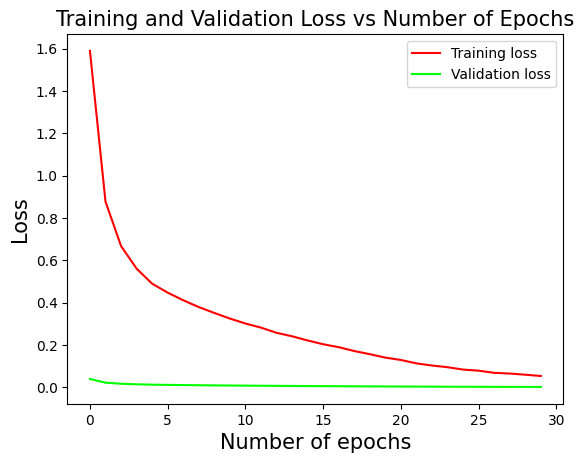

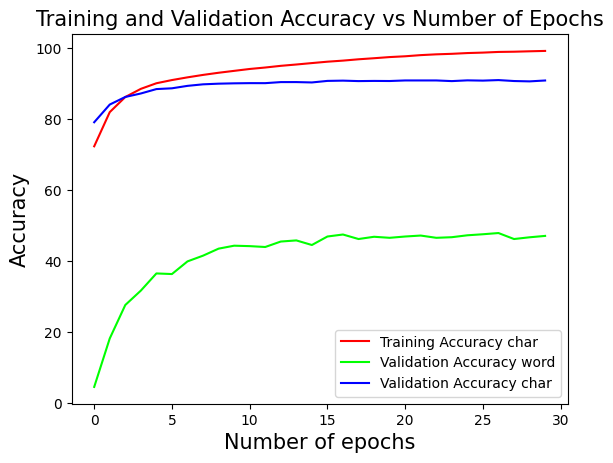

In [ ]:
best_model=train_best_model()

### predicting word by trained model and saving in csv file

In [ ]:
prediction_out_list=[]
correct_prediction_out_list=[]
for i, (inputs, target) in enumerate(test_data_set):
  inputs=inputs.to(device)

  target=target.to(device)
  
  output = best_model.prediction(inputs)#20x64x58
  
  output=torch.permute(output,(1,0,2))#64x20x58
  # output1=output[1:].reshape(-1,output.shape[2])  ########################3
  
  # output1=output[1:].argmax(2).reshape(-1)
  # target1=target[1:].reshape(-1)  
  predict=F.softmax(output,dim=1)
  predictionss=torch.argmax(predict,dim=2)
  for j in range(len(predictionss)): #len(predictions)=64 and len(predictions[j])=20
    predicted_word = ''
    target_word = ''
    source_word=''
    for k in range(len(predictionss[j])):
      if (target[j][k].item()!=55 and target[j][k].item()!=56 and target[j][k].item()!=57):
        target_word += target_id_to_char[target[j][k].item()]
      if (predictionss[j][k].item()!=55 and predictionss[j][k].item()!=56 and predictionss[j][k].item()!=57):
        if (target[j][k]==predictionss[j][k]): 
          predicted_word += target_id_to_char[predictionss[j][k].item()]
        # print(inputs[j][k])
      
      if (inputs[j][k].item()!=26 and inputs[j][k].item()!=27 and inputs[j][k].item()!=28):
        source_word+=source_id_to_char[inputs[j][k].item()]
    prediction_out_list.append([source_word,predicted_word,target_word])
    if (predicted_word==target_word):
      correct_prediction_out_list.append([source_word,predicted_word,target_word])

      

In [ ]:
files= pd.DataFrame(np.array(prediction_out_list),columns = ["Source","Predicted","Target"])

files.to_csv("Prediction.csv", index = False)

In [ ]:
files1=pd.DataFrame(np.array(correct_prediction_out_list),columns = ["Source","Predicted","Target"])
files.to_csv("Prediction1.csv",index=False)

In [ ]:


# reading the csv file
cvsDataframe = pd.read_csv('Prediction.csv')

# creating an output excel file
resultExcelFile = pd.ExcelWriter('ResultExcelFile.xlsx')

# converting the csv file to an excel file
cvsDataframe.to_excel(resultExcelFile, index=False)

# saving the excel file
resultExcelFile.save()

# Reading and Converting the output/result excel file into a dataframe object
excelDataframe=pd.read_excel('ResultExcelFile.xlsx')

# Displaying the dataframe object
print(excelDataframe)

<ipython-input-24-6ba417b2c31d>:11: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  resultExcelFile.save()


            Source Predicted    Target
0        sikhaaega     सिखएग   सिखाएगा
1            learn         ल       लरन
2         twitters      विरस    टविटरस
3      tirunelveli   तिरनलवी  तिरनलवली
4     independence         इ    इडिपडस
...            ...       ...       ...
4090       saflata     सफलता     सफलता
4091        shbana        शब     शबाना
4092  khaatootolaa     खतोला   खातटोला
4093    shivastava     शिवसत   शिवासतव
4094  preranapuree     परणाी  पररणापरी

[4095 rows x 3 columns]
